In [1]:
"""
Outlier detection using alibi-detect

Alibi Detect is an open source Python library focused on outlier, adversarial and drift detection. 
The package aims to cover both online and offline detectors for tabular data, text, 
images and time series. The outlier detection methods should allow the user to 
identify global, contextual and collective outliers.

pip install alibi-detect

https://github.com/SeldonIO/alibi-detect
Documentation: https://docs.seldon.io/_/downloads/alibi-detect/en/v0.5.1/pdf/

We will be using VAE based outlier detection. Based on this paper:
    https://arxiv.org/pdf/1312.6114.pdf
    
The Variational Auto-Encoder (VAE) outlier detector is first trained on a batch 
of unlabeled, but normal (inlier) data. Unsupervised training is desireable since 
labeled data is often scarce. The VAE detector tries to reconstruct the input it 
receives. If the input data cannot be reconstructed well, the reconstruction error 
is high and the data can be flagged as an outlier. The reconstruction error is either 
measured as the mean squared error (MSE) between the input and the reconstructed instance 
or as the probability that both the input and the reconstructed instance are 
generated by the same process.

Data set info: https://openaccess.thecvf.com/content_CVPR_2019/papers/Bergmann_MVTec_AD_--_A_Comprehensive_Real-World_Dataset_for_Unsupervised_Anomaly_CVPR_2019_paper.pdf
Data set link: https://www.mvtec.com/company/research/datasets/mvtec-ad
"""
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten

from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

##########################################################################
#Load data. We only need good data and anything NOT good is an outlier. 

image_directory = 'train'
SIZE = 64
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  

2.14.1


In [35]:
##########################################################################
#Load data. We only need good data and anything NOT good is an outlier. 

image_directory = 'train/'
SIZE = 64
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  

good_images = os.listdir(image_directory + 'good/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'good/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))

dataset = np.array(dataset)

train = dataset[0:300]
test = dataset[300:]

train = train.astype('float32') / 255.
test = test.astype('float32') / 255.

In [54]:
#Let us also load bad images to verify our trained model. 
bad_images = os.listdir(image_directory + 'bad')
bad_dataset=[]
for i, image_name in enumerate(bad_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'bad/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        bad_dataset.append(np.array(image))
bad_dataset = np.array(bad_dataset)
bad_dataset = bad_dataset.astype('float32') / 255.

In [55]:
bad_dataset.shape

(20, 64, 64, 3)

In [38]:
#########################################################################
#Define the encoder - decoder network for input to the OutlierVAE detector class. 
#Can be any encoder and decoder. 

from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense
import tensorflow as tf

encoding_dim = 1024  # Bottleneck latent space dimension

encoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=train[0].shape),  # Match input shape from train data
        Conv2D(64, 4, strides=2, padding='same', activation='relu'),   # First Conv layer
        Conv2D(128, 4, strides=2, padding='same', activation='relu'),  # Second Conv layer
        Conv2D(256, 4, strides=2, padding='same', activation='relu'),  # Third Conv layer
        Conv2D(512, 4, strides=2, padding='same', activation='relu'),  # Fourth Conv layer
        Flatten(),                                                     # Flatten output for Dense layer
        Dense(encoding_dim, activation='relu')                         # Bottleneck Dense layer
    ]
)

print(encoder_net.summary())
#print(encoder_net.input_shape)

#Define the decoder. 
#Start with the bottleneck dimension (encoder vector) and connect to dense layer 
#with dim = total nodes in the last conv. in the encoder. 
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose

# Correct the Dense layer output size to match the encoder's last convolutional output dimensions
dense_dim = [8, 8, 1024]  # Matches the output shape of the encoder's last convolutional layer
decoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(1024,)),                          # Input matches the encoder bottleneck size
        Dense(np.prod(dense_dim), activation='relu'),            # Dense layer expands to 8x8x512 = 32,768
        Reshape(target_shape=dense_dim),                         # Reshape into spatial dimensions [8, 8, 512]
        Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu'),  # Upsample to [16, 16, 256]
        Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu'),  # Upsample to [32, 32, 128]
        Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu'),   # Upsample to [64, 64, 64]
        Conv2DTranspose(3, 4, strides=1, padding='same', activation='sigmoid')  # Final output [64, 64, 3]
    ]
)

print(decoder_net.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 256)         524544    
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 512)         2097664   
                                                                 
 flatten_3201 (Flatten)      (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              8389632   
                                                                 
Total params: 11146176 (42.52 MB)
Trainable params: 11

In [6]:
sample_input = np.random.rand(1, 64, 64, 3).astype('float32')  # Example input
encoder_output = encoder_net(sample_input)
print("Encoder output shape:", encoder_output.shape)


Encoder output shape: (1, 1024)


In [39]:
#######################################################################
#Define and train the outlier detector. 

latent_dim = 1024  #(Same as encoding dim. )

# initialize outlier detector
od = OutlierVAE(threshold=.002,  # threshold for outlier score above which the element is flagged as an outlier.
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=10)

print("Current threshold value is: ", od.threshold)
# train
adam = tf.keras.optimizers.Adam(lr=1e-5)

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

od.fit(train,
       optimizer=adam,
       epochs=40,
       batch_size=8,
       verbose=True,
       callbacks=[early_stopping])


#Check the threshold value. Should be the same as defined before. 
print("Current threshold value is: ", od.threshold)

#
#infer_threshold Updates threshold by a value inferred from the percentage of 
#instances considered to be outliers in a sample of the dataset.
#percentage of X considered to be normal based on the outlier score.
#Here, we set it to 99%
od.infer_threshold(test, outlier_type='instance', threshold_perc=99.0)
print("Current threshold value is: ", od.threshold)


# save the trained outlier detector
#As mentioned in their documentation, save and load is having issues in python3.6 but works fine in 3.7
#from alibi_detect.utils import save_detector, load_detector  #If this does not work, try the next line
#from alibi_detect.utils.saving import save_detector, load_detector #Use this if the above line does not work. 
#save_detector(od, "saved_outlier_models/carpet_od_20epochs.h5")
#od = load_detector(filepath)


Current threshold value is:  0.002
38/38 [=] - 75s 2s/step - loss_ma: -20275.8871
Current threshold value is:  0.002
Current threshold value is:  0.004574156971648333


In [40]:
#Here, we set it to 90%

od.infer_threshold(test, outlier_type='instance', threshold_perc=90.0)
print("Current threshold value is: ", od.threshold)


Current threshold value is:  0.0031686974689364433


In [13]:
#od.threshold = 0.0035  # Adjust based on the histogram


In [41]:
from alibi_detect.utils.saving import save_detector, load_detector

# Save detector
save_detector(od, "haz_od_vae")

# Load detector
od_loaded = load_detector("haz_od_vae")


C:\Users\sraj\AppData\Local\miniforge3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


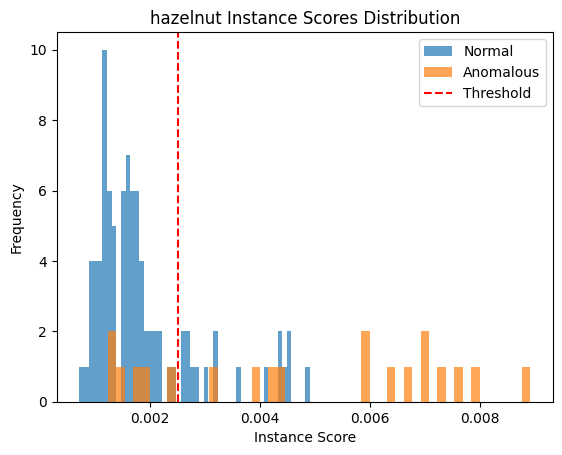

In [61]:
# Predict scores for normal and anomalous datasets
od.threshold = 0.0025 
normal_preds = od.predict(test, outlier_type='instance')['data']['instance_score']
anomalous_preds = od.predict(bad_dataset, outlier_type='instance')['data']['instance_score']

# Plot instance scores
import matplotlib.pyplot as plt

plt.hist(normal_preds, bins=50, alpha=0.7, label='Normal')
plt.hist(anomalous_preds, bins=50, alpha=0.7, label='Anomalous')
plt.axvline(od.threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title('hazelnut Instance Scores Distribution')
plt.xlabel('Instance Score')
plt.ylabel('Frequency')
plt.show()


The instance score is: 0.004237455
Is this image an outlier (0 for NO and 1 for YES)? 1


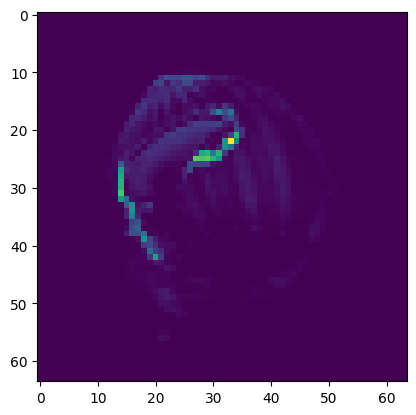

In [44]:
#Test our model on a bad image
img_num = 11
test_bad_image = bad_dataset[img_num].reshape(1, 64, 64, 3)
plt.imshow(test_bad_image[0])

test_bad_image_recon = od.vae(test_bad_image)
test_bad_image_recon = test_bad_image_recon.numpy()
plt.imshow(test_bad_image_recon[0])

test_bad_image_predict = od.predict(test_bad_image) #Returns a dictionary of data and metadata

#Data dictionary contains the instance_score, feature_score, and whether it is an outlier or not. 
#Let u look at the values under the 'data' key in our output dictionary
bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
print("The instance score is:", bad_image_instance_score)

bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
#print("The feature score is:", bad_image_feature_score)

plt.imshow(bad_image_feature_score[:,:,0])
print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])


['instance_score', 'feature_score', 'is_outlier']


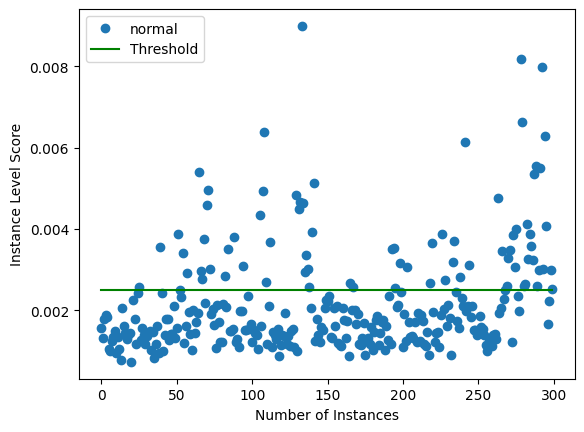

In [45]:
#Let us check it for multiple images
X = train[0:]

od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

print(list(od_preds['data'].keys()))

#Scatter plot of instance scores. using the built-in function for the scatterplot. 
target = np.zeros(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) #pred, target, labels, threshold

['instance_score', 'feature_score', 'is_outlier']


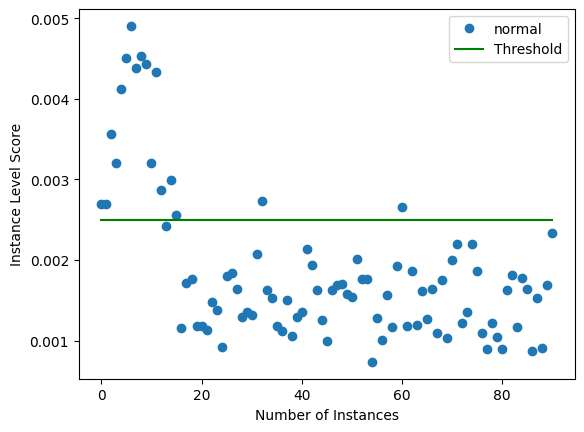

In [46]:
#Let us check it for multiple images
X = test[0:]

od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

print(list(od_preds['data'].keys()))

#Scatter plot of instance scores. using the built-in function for the scatterplot. 
target = np.zeros(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) #pred, target, labels, threshold

['instance_score', 'feature_score', 'is_outlier']


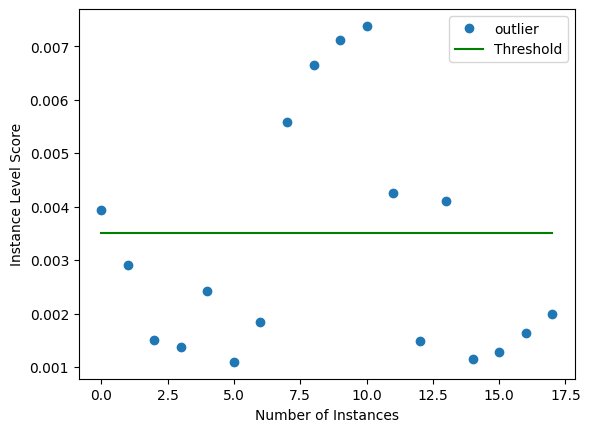

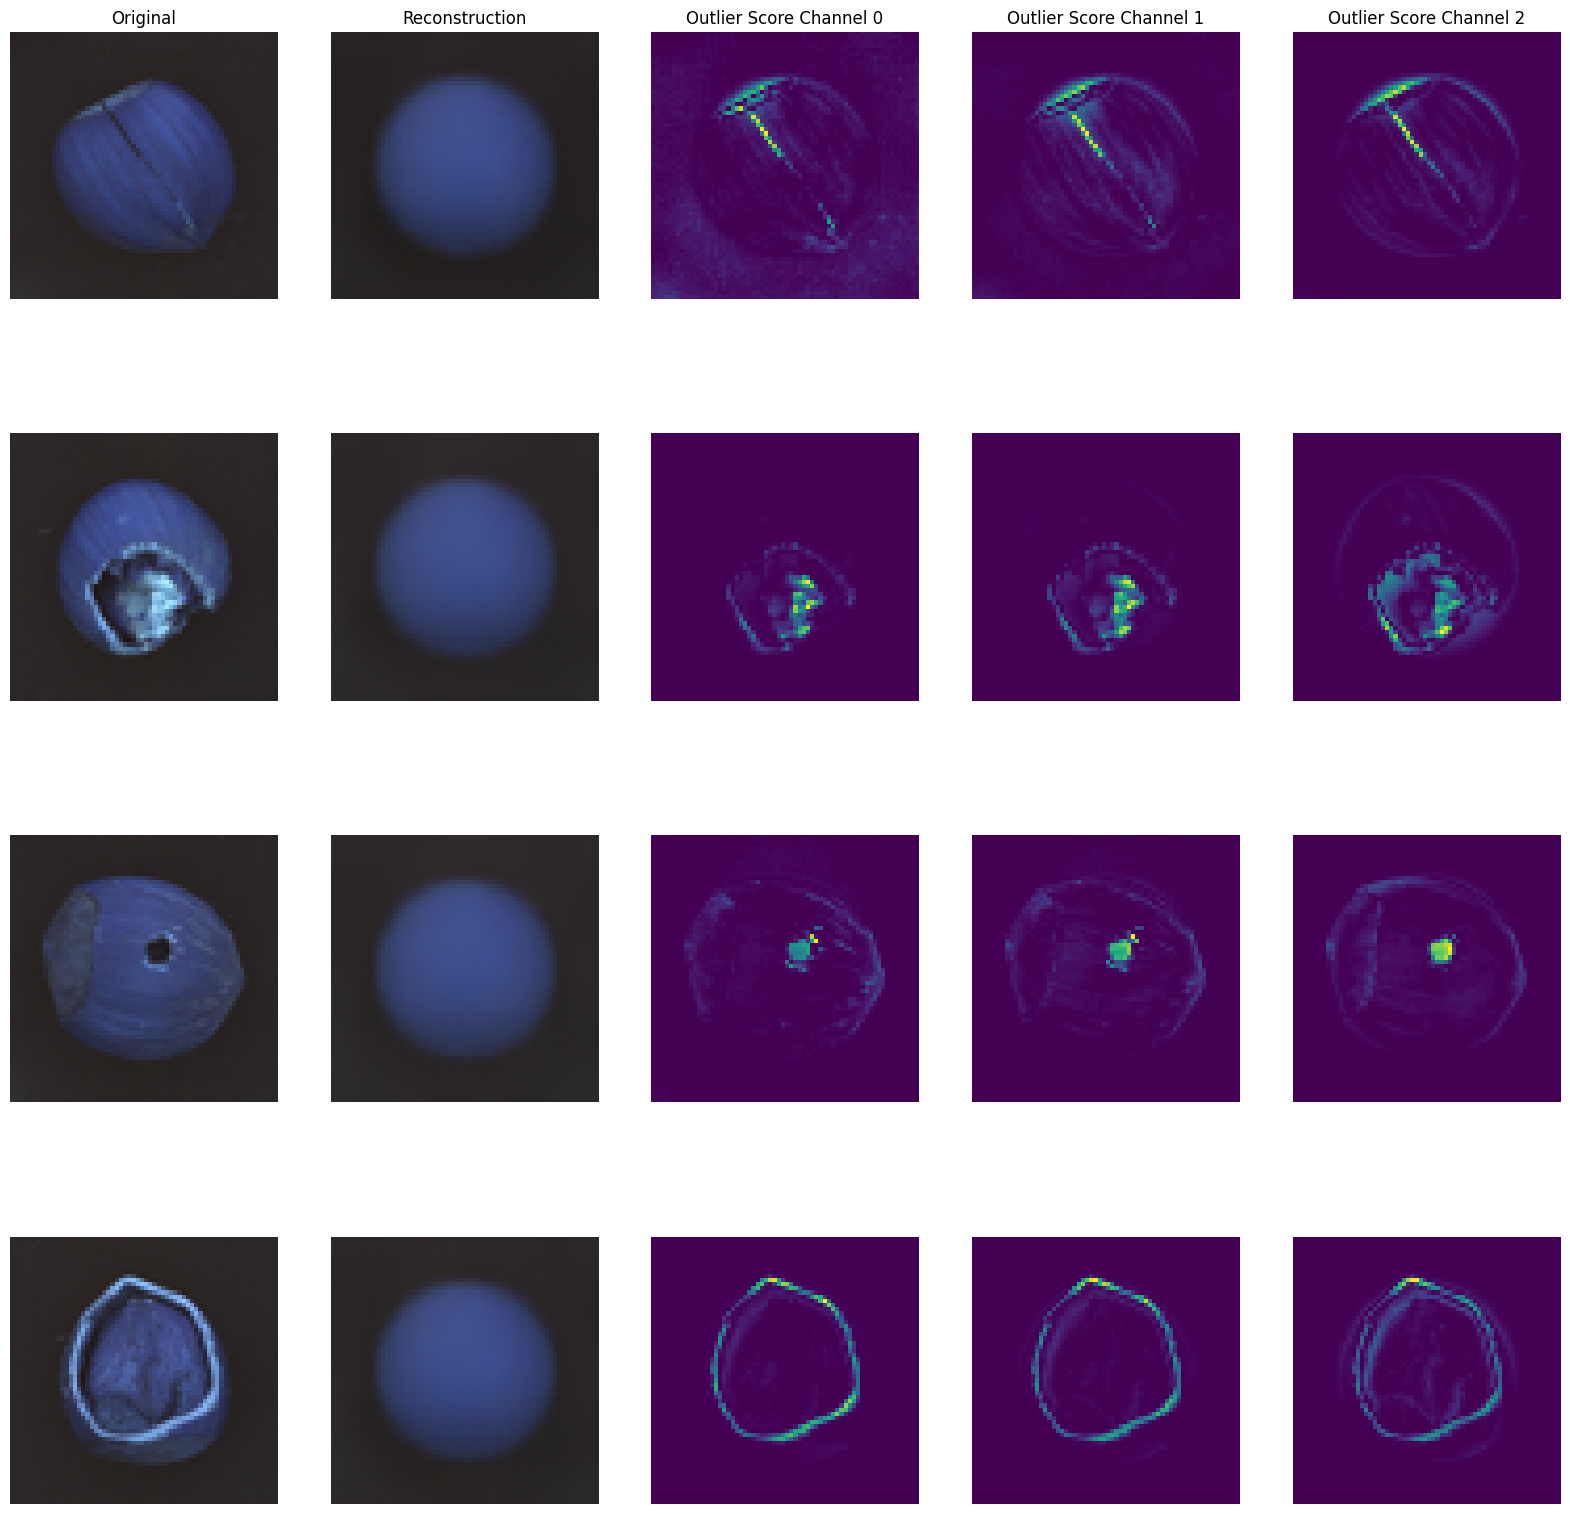

In [30]:
#Let us check it for multiple images
#od.threshold = 0.0023
X = bad_dataset[0:]

od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

print(list(od_preds['data'].keys()))

#Scatter plot of instance scores. using the built-in function for the scatterplot. 
target = np.ones(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) #pred, target, labels, threshold

#Plot features for select images, using the built in function (plot_feature_outlier_image)
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           instance_ids=[5, 8, 16, 10],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=True)  # only show outlier predictions

#######################################

Current threshold value is:  0.0025
[1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1]
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         0
     Outlier       1.00      0.70      0.82        20

    accuracy                           0.70        20
   macro avg       0.50      0.35      0.41        20
weighted avg       1.00      0.70      0.82        20



C:\Users\sraj\AppData\Local\miniforge3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sraj\AppData\Local\miniforge3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sraj\AppData\Local\miniforge3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


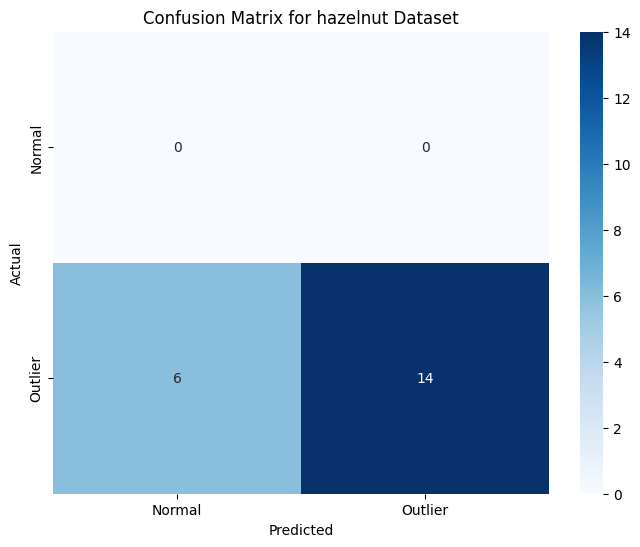

Accuracy: 70.00%


In [62]:
from sklearn.metrics import classification_report, confusion_matrix  # Import the necessary metrics
import seaborn as sns  # Import seaborn for plotting
from sklearn.metrics import accuracy_score

# we can manually assign the threshold
#od.threshold = 0.002028291973192245

# Replace this with the actual labels from your dataset
print("Current threshold value is: ", od.threshold)
#print(test)
true_labels_bad = np.ones(len(bad_dataset))  
#print(true_labels_good)
# Predict outliers on the test dataset
od_preds = od.predict(bad_dataset,
                      outlier_type='instance',
                      return_feature_score=True,
                      return_instance_score=True)

# Retrieve the instance scores
instance_scores_bad = od_preds['data']['instance_score']
predicted_labels_bad = (instance_scores_bad > od.threshold).astype(int)

#predicted_labels_bad= [0 if score <= od.threshold else 1 for score in instance_scores_bad]
print(predicted_labels_bad)
# Generate classification report
report = classification_report(true_labels_bad, predicted_labels_bad, target_names=['Normal', 'Outlier'], labels=[0, 1])
print(report)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels_bad, predicted_labels_bad)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Outlier'], yticklabels=['Normal', 'Outlier'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for hazelnut Dataset')
plt.show()
# Calculate accuracy
accuracy = accuracy_score(true_labels_bad, predicted_labels_bad)
print(f"Accuracy: {accuracy * 100:.2f}%")

              precision    recall  f1-score   support

      Normal       0.97      0.75      0.85       300
     Outlier       0.16      0.70      0.26        20

    accuracy                           0.75       320
   macro avg       0.57      0.72      0.55       320
weighted avg       0.92      0.75      0.81       320



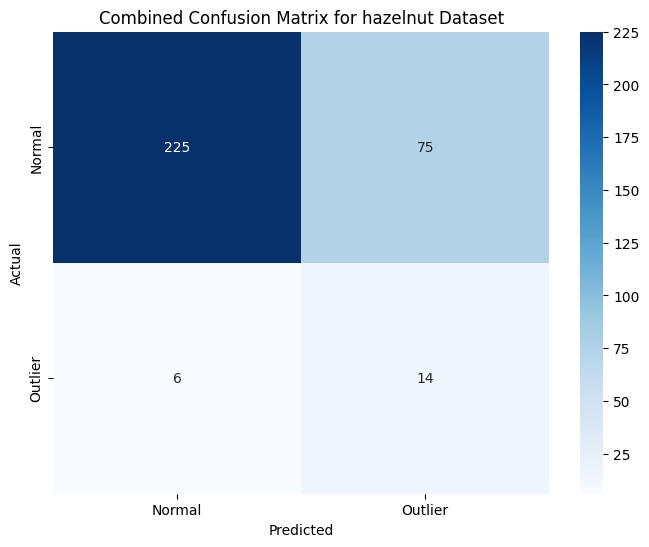

In [63]:
# True labels for good dataset
true_labels_good = np.zeros(len(train))

# Predict outliers on good dataset
od_preds_good = od.predict(train,
                           outlier_type='instance',
                           return_feature_score=True,
                           return_instance_score=True)

# Predicted labels for good dataset
instance_scores_good = od_preds_good['data']['instance_score']
predicted_labels_good = (instance_scores_good > od.threshold).astype(int)

# Combine labels
true_labels = np.concatenate([true_labels_good, true_labels_bad])
predicted_labels = np.concatenate([predicted_labels_good, predicted_labels_bad])

# Generate combined report
report = classification_report(true_labels, predicted_labels, target_names=['Normal', 'Outlier'])
print(report)

# Plot combined confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Outlier'], yticklabels=['Normal', 'Outlier'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Combined Confusion Matrix for hazelnut Dataset')
plt.show()


In [65]:
# Combine normal test and anomalous datasets
combined_test = np.concatenate([test, bad_dataset], axis=0)

# Create true labels (0 for normal, 1 for anomalous)
true_labels = [0] * len(test) + [1] * len(bad_dataset)

# Predict on the combined test set
od_preds_combined = od.predict(combined_test, outlier_type='instance')
combined_instance_scores = od_preds_combined['data']['instance_score']

# Compute metrics (e.g., ROC-AUC)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(true_labels, combined_instance_scores)
print(f"Combined Test ROC-AUC: {roc_auc:.2f}")


Combined Test ROC-AUC: 0.84


In [66]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Extract instance scores if necessary
if isinstance(od_preds_combined, dict):
    od_preds_combined = od_preds_combined['data']['instance_score']

# Ensure scores are numerical
predicted_labels = [1 if score > od.threshold else 0 for score in od_preds_combined]

# Compute evaluation metrics
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, od_preds_combined)  # Pass scores directly for ROC-AUC

# Print metrics
print("hazelnut Dataset")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")


hazelnut Dataset
Precision: 0.45
Recall: 0.70
F1-Score: 0.55
ROC-AUC: 0.84
